## Libraries

In [1]:
import csv
import json
from pprint import pp
import os
import numpy as np
from numpy.linalg import norm
import pandas as pd


FCSV_FIELDS = (
    "id",
    "x",
    "y",
    "z",
    "ow",
    "ox",
    "oy",
    "oz",
    "vis",
    "sel",
    "lock",
    "label",
    "desc",
    "associatedNodeID",
)


def read_fcsv(fcsv_path):
    with open(fcsv_path, "r", encoding="utf-8") as fcsv_file:
        return {
            row["desc"].lower(): np.array(
                [float(row["x"]), float(row["y"]), float(row["z"])]
            )
            for row in csv.DictReader(fcsv_file, fieldnames=FCSV_FIELDS)
            if row["desc"] not in ["desc", None]
        }


def calc_afles(ground_truth_path, model_path):
    ground_truth_afids = read_fcsv(ground_truth_path)
    model_afids = read_fcsv(model_path)

    #print("Ground truth:")
    #pp(ground_truth_afids)
   # print("Model:")
   # pp(model_afids)

    return {
        key: norm(ground_truth_afids[key] - model_afids[key])
        for key in ground_truth_afids.keys()
    }


def main(AFIDs_DIR,PRED_DIR):
    afles = calc_afles(AFIDs_DIR, PRED_DIR)
    #print("AFLEs:")
    afles["mean"] = np.mean(np.array(list(afles.values())))
    #pp(afles["mean"])
    #print (f'min: {afles.values().min()}')
    #print (f'max: {afles.values().max()}')
    
    with open(f'{OUTPUT_DIR}/{SUBJECT}/anat/{SUBJECT}.txt', "w", encoding="utf-8") as afle_file:
        json.dump(afles, afle_file) 
    return afles["mean"], afles

#write results into fcsv file 
def seg_to_fcsv(weighted_centroids, fcsv_template, fcsv_output):
    # Read in fcsv template
    with open(fcsv_template, "r") as f:
        fcsv = [line.strip() for line in f]

    # Loop over fiducials
    for fid in range(1, 33):
        # Update fcsv, skipping header
        line_idx = fid + 2
        centroid_idx = fid - 1
        fcsv[line_idx] = fcsv[line_idx].replace(
            f"afid{fid}_x", str(weighted_centroids[centroid_idx][0])
        )
        fcsv[line_idx] = fcsv[line_idx].replace(
            f"afid{fid}_y", str(weighted_centroids[centroid_idx][1])
        )
        fcsv[line_idx] = fcsv[line_idx].replace(
            f"afid{fid}_z", str(weighted_centroids[centroid_idx][2])
        )

    # Write output fcsv
    with open(fcsv_output, "w") as f:
        f.write("\n".join(line for line in fcsv))

In [2]:
USER = 'ataha'
DATASET = 'HCP'
BASE_DIR = f'/home/ROBARTS/ataha/graham/projects/ctb-akhanf/ataha24/5.afids_CNN/data/{DATASET}'
OUTPUT_DIR = f'{BASE_DIR}/derivatives/mni'

SUBJECT_IDS = [
    subject for subject in os.listdir(f'{BASE_DIR}/derivatives/mni') if "sub-" in subject]

print(SUBJECT_IDS)

['sub-130013', 'sub-156637', 'sub-199655', 'sub-245333', 'sub-212318', 'sub-151526', 'sub-103111', 'sub-160123', 'sub-899885', 'sub-123925', 'sub-148840', 'sub-105014', 'sub-239944', 'sub-856766', 'sub-654754', 'sub-115320', 'sub-139637', 'sub-751348', 'sub-149539', 'sub-140925', 'sub-163129', 'sub-122620', 'sub-201111', 'sub-151627', 'sub-178950', 'sub-108828', 'sub-366446', 'sub-113922', 'sub-130316', 'sub-147737']


In [3]:
for sub in SUBJECT_IDS:
    SUBJECT = sub
    xfm_txt = f'/home/ROBARTS/ataha/graham/projects/ctb-akhanf/ataha24/aah-oasisvshcp/afids_auto_harness/output/afids/patchsize-6x6x6x0_ntrees-100_treedepth-50_usexyz-True_spheresize-2/reg_aladin/{SUBJECT}/anat/{SUBJECT}_acq-MP2RAGE_space-MNI152NLin2009cAsym_xfm.txt'
    fcsv_source = f'{BASE_DIR}/derivatives/mni/{SUBJECT}/anat/{SUBJECT}.fcsv'
    fcsv_new = f'{OUTPUT_DIR}/{SUBJECT}/anat/{SUBJECT}_acq-MP2RAGE_space-native_predicted_afids.fcsv'
    
    if os.path.splitext(xfm_txt)[1] == '.tfm': 
        print("reading .tfm file")
        with open(xfm_txt) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            for row in csv_reader:
                lis= (list(csv_reader)[2][0]).split()[1:]
                arr = np.asarray(lis, dtype = np.float64)
                sub2template=np.array([[  arr[0],  -arr[3], -arr[6],  arr[9] ] ,
                              [arr[1],   arr[4], -arr[7],  arr[10] ]  ,
                             [ -arr[2],  -arr[5],  arr[8],  -arr[11]]   ,
                              [0     ,   0     ,   0    ,   1       ]])
    else: 
        print("reading .txt file")
        # load transform from subj to template
        sub2template = np.loadtxt(xfm_txt)

    fcsv_df = pd.read_table(fcsv_source, sep=",", header=2)
    coords = fcsv_df[["x", "y", "z"]].to_numpy() #coords of MNI afids before propagating to subject space

    # to plot in mni space, need to transform coords
    tcoords = np.zeros(coords.shape)
    for i in range(len(coords)):
        vec = np.hstack([coords[i, :], 1])
        if os.path.splitext(xfm_txt)[1] == '.tfm': 
            tvec = np.linalg.inv(sub2template) @ vec.T
        else: 
            tvec = (sub2template) @ vec.T
        tcoords[i, :] = tvec[:3] #coordiantes of MNI afids after propagating to subject space 

    seg_to_fcsv(tcoords,'/home/ROBARTS/ataha/Desktop/afids-auto/afids-auto-apply/resources/afids_template.fcsv',fcsv_new)

reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file
reading .txt file


In [4]:
global_afle = [] 
for n in SUBJECT_IDS:
    SUBJECT = n
    #fcsv_new = f'{BASE_DIR}/threshold_prob/{SUBJECT}/anat/{SUBJECT}_acq-MP2RAGE_space-native_afids.fcsv'

    AFIDs_DIR = f'/home/ROBARTS/ataha/graham/projects/ctb-akhanf/akhanf/cfmm-bids/data/Khan/clinical_imaging/autoafids/data/HCP/derivatives/afids_groundtruth/{SUBJECT}/{SUBJECT}_space-T1w_desc-groundtruth_afids.fcsv'
    PRED_DIR = f'{BASE_DIR}/derivatives/mni/{SUBJECT}/anat/{SUBJECT}_acq-MP2RAGE_space-native_predicted_afids.fcsv'
    global_afle.append(main(AFIDs_DIR, PRED_DIR))

In [6]:
list_inner = [] 
for sub in range (0,30): 
    #print(list(global_afle[sub][1].values())[:-1])
    list_inner.append(list((global_afle[sub][1].values()))[:-1])

In [7]:
df = pd.DataFrame(list_inner, columns = list(global_afle[0][1].keys())[:-1]) 

In [8]:
df.describe()

#from scipy import stats
#df[(np.abs(stats.zscore(df)) < 3).all(axis=1)].describe()

,ac,pc,infracollicular sulcus,pmj,superior interpeduncular fossa,r superior lms,l superior lms,r inferior lms,l inferior lms,culmen,...,r superior am temporal horn,l superior am temporal horn,r inferior am temporal horn,l inferior am temporal horn,r indusium griseum origin,l indusium griseum origin,r ventral occipital horn,l ventral occipital horn,r olfactory sulcal fundus,l olfactory sulcal fundus
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2.335522,2.739420,3.026171,1.812298,1.857709,1.815118,2.478080,1.518165,1.678594,4.120630,...,2.228280,2.781117,3.261457,4.744230,4.291269,3.497893,4.501750,4.087646,3.343570,3.032537
std,1.203399,1.020983,1.993107,0.787229,0.626670,0.668878,1.092268,0.892093,1.893069,2.270908,...,1.024660,1.760062,1.548168,2.138947,1.566085,1.596124,1.692471,3.203324,1.413002,1.454471
min,0.340176,0.603211,0.765924,0.547616,0.666159,0.802724,0.973470,0.389745,0.401687,1.326537,...,0.485204,0.671355,0.730004,1.747805,1.977598,0.964231,1.856465,1.184970,1.016614,0.510643
25%,1.468417,2.172149,1.400955,1.239131,1.531399,1.350440,1.624298,0.787668,0.785675,2.587032,...,1.571230,1.723078,2.057633,3.377183,3.034775,2.288244,3.198383,2.194397,2.174048,1.852735
50%,2.240367,2.627179,2.495523,1.692943,1.912508,1.693016,2.152545,1.384013,1.126558,3.553458,...,1.982651,2.437296,3.338622,4.330478,4.265387,3.435952,4.365927,3.340816,3.371460,3.036776
75%,2.846070,3.602475,4.306376,2.015027,2.215245,2.235813,3.192468,1.978798,1.716746,4.734766,...,2.731962,3.195250,4.181085,5.388383,5.224686,4.431438,5.864647,4.661585,4.336488,4.116289
max,5.819662,4.642032,6.845953,4.057992,3.364755,3.739412,4.824430,4.451280,10.559394,11.722995,...,4.677688,9.173688,6.517986,12.517822,8.062031,8.685978,7.749738,17.438589,6.465677,5.974222


In [10]:
df

,ac,pc,infracollicular sulcus,pmj,superior interpeduncular fossa,r superior lms,l superior lms,r inferior lms,l inferior lms,culmen,...,r superior am temporal horn,l superior am temporal horn,r inferior am temporal horn,l inferior am temporal horn,r indusium griseum origin,l indusium griseum origin,r ventral occipital horn,l ventral occipital horn,r olfactory sulcal fundus,l olfactory sulcal fundus
0,2.687447,2.202349,6.811969,2.764688,1.941480,1.650719,3.665211,1.650466,0.625679,4.583037,...,3.025860,1.775245,3.740294,4.735891,8.062031,5.021669,3.064675,5.460734,1.625417,1.314227
1,2.249324,2.395738,1.888877,1.471922,1.540276,1.821463,2.145298,1.675716,0.674259,3.461479,...,2.501481,5.941939,2.081960,4.062810,2.362514,4.222485,1.856465,3.672000,1.852031,3.210667
2,1.943360,2.806185,6.392544,1.576948,1.990667,1.346411,4.641800,0.389745,0.401687,1.326537,...,1.355438,6.335603,3.163109,4.612576,5.803442,1.846280,4.895471,2.513557,3.500070,1.443226
3,0.989958,2.162082,0.916755,1.034052,1.304527,1.641354,2.159792,0.780778,1.543936,3.056916,...,1.070119,2.431093,1.125350,1.747805,2.696726,3.415541,3.724328,2.283973,4.343833,4.712630
4,1.662586,0.796964,0.782002,1.896003,1.371306,1.819426,1.548505,2.786944,2.013261,5.346108,...,1.947458,3.355614,3.514136,4.528873,3.268725,2.026537,3.922828,2.118716,4.314451,1.948591
5,1.205092,2.788215,3.146302,0.547616,1.065244,1.613480,2.327958,1.055705,2.273146,3.291682,...,3.583578,1.705689,2.094151,3.211052,5.217758,0.964231,2.136034,17.438589,2.820860,1.221296
6,2.814906,2.156667,5.373456,1.967269,2.487057,3.739412,3.972417,1.824504,1.485484,4.686691,...,3.349647,2.443499,3.826388,6.833261,5.557087,2.222683,6.437714,3.408478,6.465677,3.766798
7,1.491310,4.474654,1.086164,1.210251,2.086297,2.283106,0.973470,1.695830,2.051164,3.820304,...,1.718661,2.968132,1.993559,5.880552,3.411753,2.892219,2.501842,4.742826,3.707267,3.049652
8,2.255922,1.952225,0.946259,1.124696,1.657060,1.441420,1.890595,1.358437,0.941307,2.087060,...,2.017845,1.081987,0.730004,3.927165,2.152905,3.054055,4.194798,2.807569,2.083945,2.794083
9,4.341504,2.595393,2.140669,2.707622,2.738187,2.462225,4.505867,0.808336,1.600236,2.035227,...,1.198035,2.528592,6.507200,4.011881,6.267435,4.909192,5.937939,3.522261,4.509096,3.213352


In [11]:
df.to_csv('HCP_CNN_raw.csv')
df.describe().to_csv('HCP_CNN_summary.csv')

In [14]:
pwd

'/home/ROBARTS/ataha/Desktop/auto-afids/notebooks'

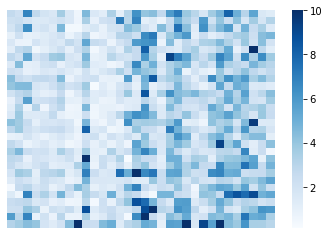

In [12]:
import seaborn as sns

ax = sns.heatmap(df,linecolor = 'black',xticklabels = False, yticklabels = False ,annot = False, cmap = "Blues", vmax = 10)
ax.set(xlabel="", ylabel="")
sns.set(rc={'figure.figsize':(30,32)})
ax.figure.savefig("sns-heatmap.png",dpi=300)

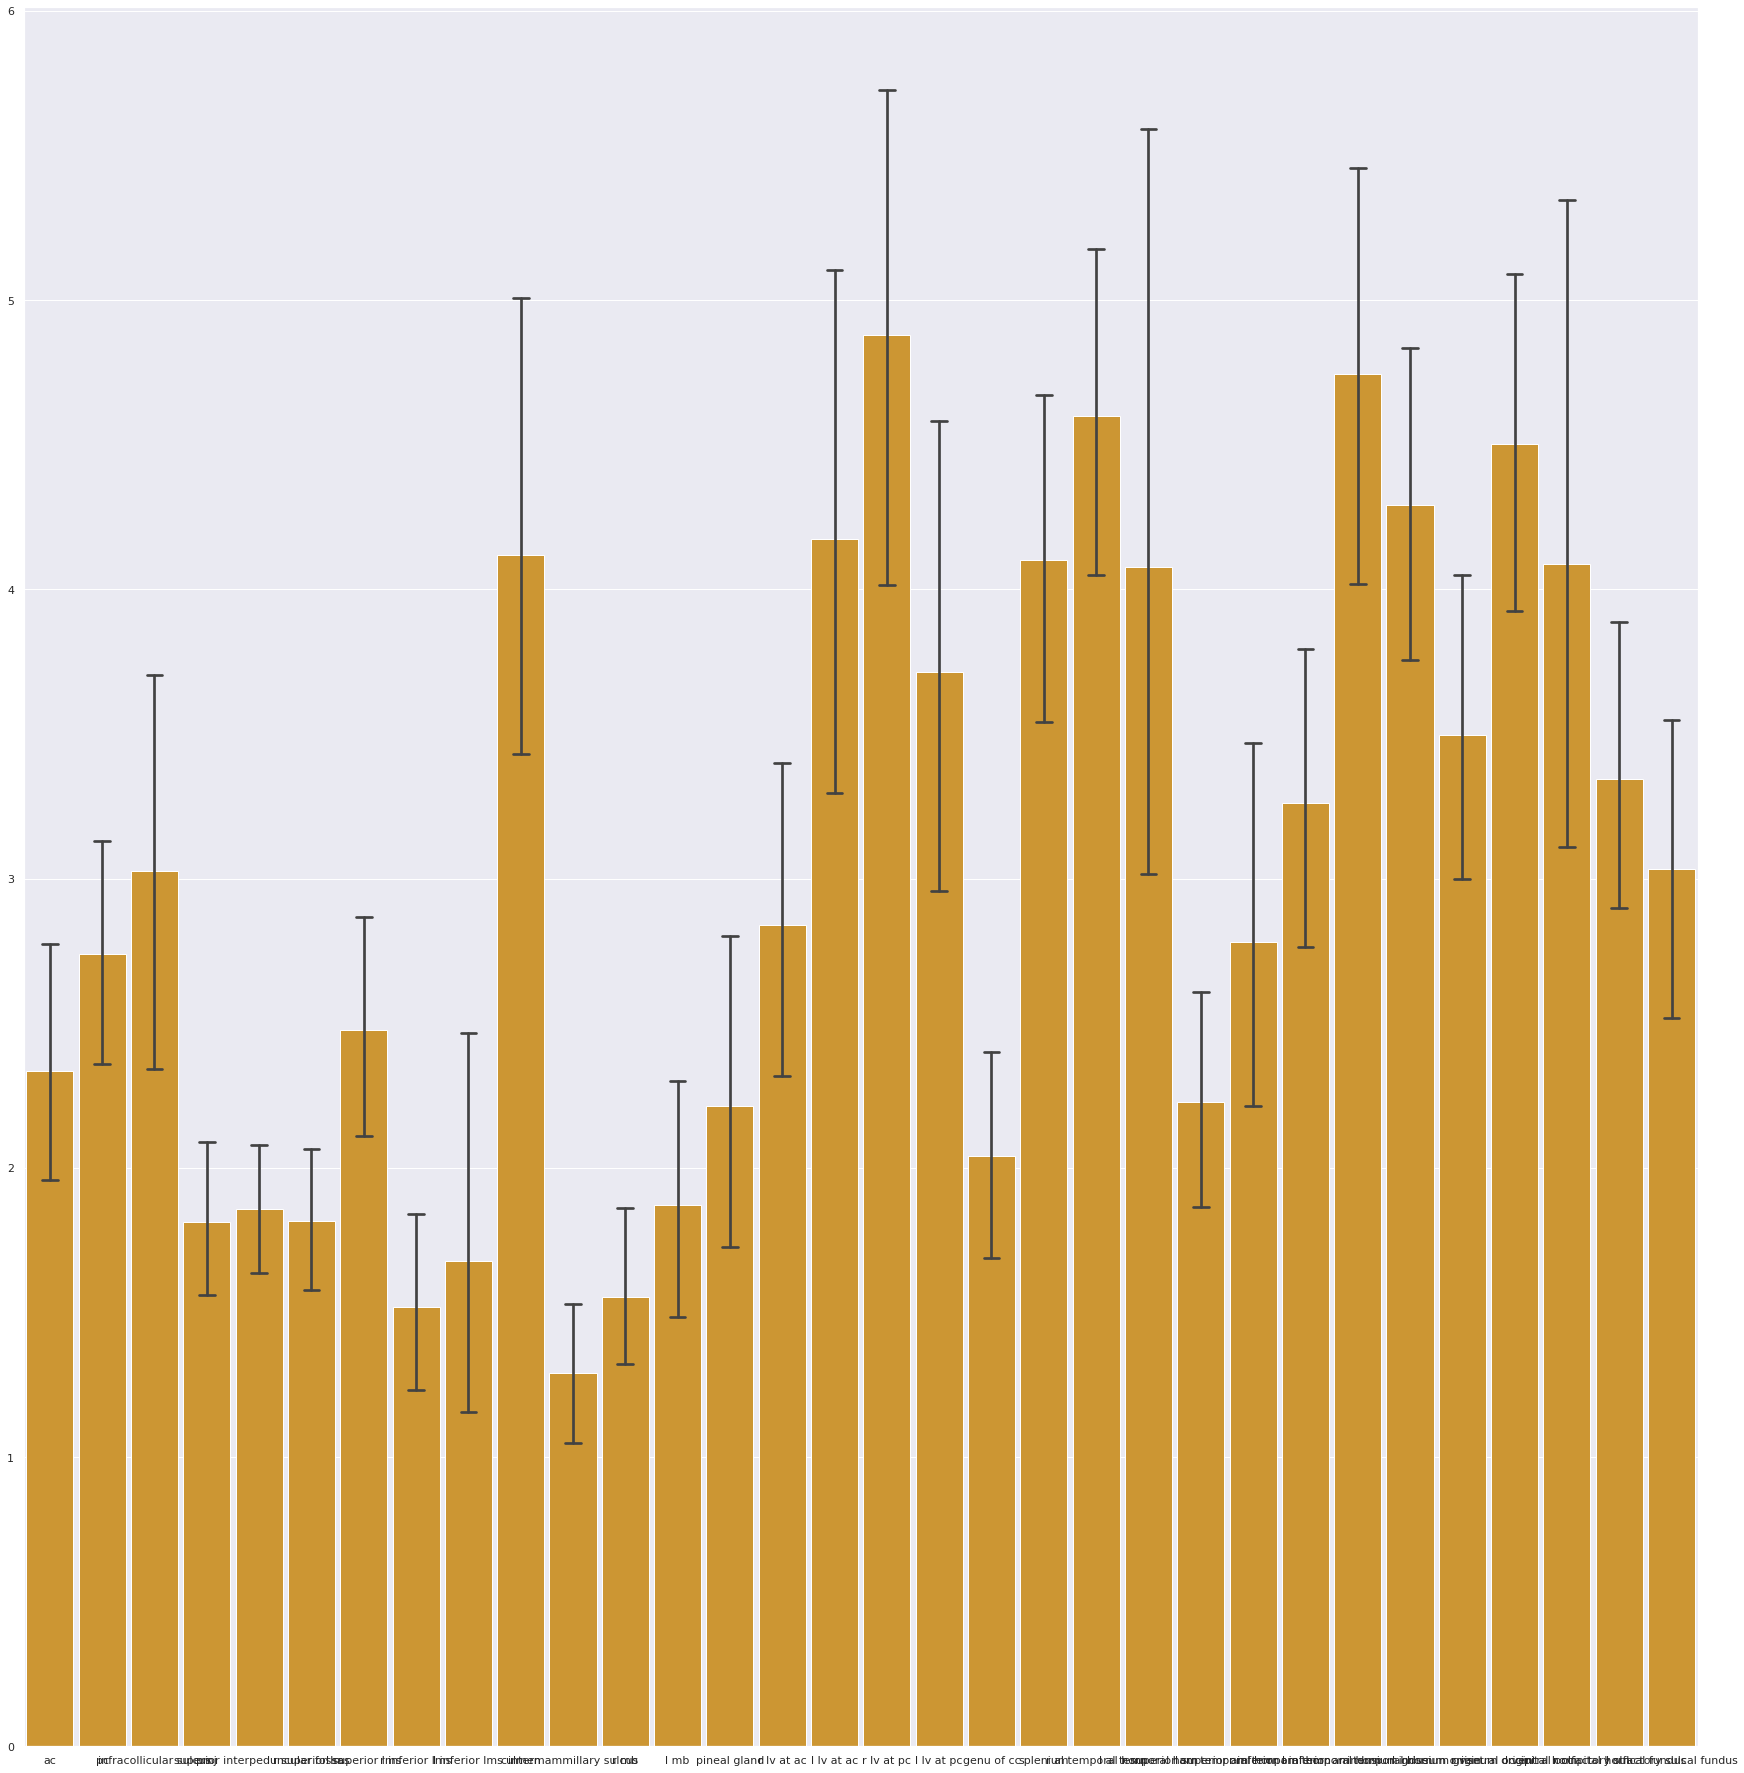

In [13]:
plt = sns.barplot(df, color='orange',saturation=0.6,width=0.9,capsize=0.3)
plt.figure.savefig("sns-heatmap_bar.png",dpi=300)

In [108]:
# df.plot.bar()
# plt.xticks(rotation=0)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()